In [1]:
from pydantic import BaseModel
from typing import Optional, Literal
from langchain_core.output_parsers import PydanticOutputParser
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display, Markdown

from router import Router
from not_defined import NotDefined
from meetings_info import MeetingsInfo
from places_info import PlacesInfo
from set_meeting import SetMeeting
from aggregator import Aggregator

from utils import get_console_logger

In [2]:
# logging
logger = get_console_logger()

In [3]:
# this class define the schema to follow for the output
class State(BaseModel):
    """
    Defines the internal state of the agent.
    """

    input: str

    # here the enumeration of possible next steps
    # important to make optional: at the beginning of the flow it is undefined
    decision: Optional[
        Literal["meetings_info", "places_info", "set_meeting", "not_defined"]
    ] = None
    output: str = ""

In [4]:
#
# adding few shots to improve the accuracy of decisions in routing
#
few_shots = [
    {
        "input": "When in this week I will be free for lunch/dinner?",
        "output": {"decision": "meeting_info", "output": ""},
    },
    {
        "input": "Can you arrange a meeting with Alex and Martijn??",
        "output": {"decision": "set_meeting", "output": ""},
    },
]

router = Router(model=State, few_shot_examples=few_shots)

#### Test the routing

In [5]:
queries = [
    "I want information about restaurants in London",
    "I need the list of the meetings of last week",
    "When I have one hour free next week?",
    "I want to know what I don't know",
    "When in this week I will be free for lunch/dinner?",
    "Give me all the free slot for 2025-02-28",
    "Give me all the available slot for 2025-02-26",
    "Please book a meeting slot for 2025-03-10 11 AM",
    "Set a meeting with Ansh for today 11 AM",
    "Arrange a meeting with Ansh for next tuesday",
]

In [6]:
for query in queries:
    print("")
    print(query)

    response = router.route(State(input=query))
    print("next step is: ", response.decision)


I want information about restaurants in London
next step is:  places_info

I need the list of the meetings of last week
next step is:  meetings_info

When I have one hour free next week?
next step is:  meetings_info

I want to know what I don't know
next step is:  not_defined

When in this week I will be free for lunch/dinner?
next step is:  meetings_info

Give me all the free slot for 2025-02-28
next step is:  meetings_info

Give me all the available slot for 2025-02-26
next step is:  meetings_info

Please book a meeting slot for 2025-03-10 11 AM
next step is:  set_meeting

Set a meeting with Ansh for today 11 AM
next step is:  set_meeting

Arrange a meeting with Ansh for next tuesday
next step is:  set_meeting


### Define the agent

In [7]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    """
    return only the next step name
    """
    return state.decision


# Build workflow graph
agent_builder = StateGraph(State)

# create the nodes with logic
meetings_info = MeetingsInfo()
places_info = PlacesInfo()
not_defined = NotDefined()
set_meeting = SetMeeting()
aggregator = Aggregator()

# Add nodes
agent_builder.add_node("meetings_info", meetings_info)
agent_builder.add_node("places_info", places_info)
agent_builder.add_node("not_defined", not_defined)
agent_builder.add_node("set_meeting", set_meeting)


agent_builder.add_node("aggregator", aggregator)
agent_builder.add_node("router", router.route)

# Add edges to connect nodes
agent_builder.add_edge(START, "router")

agent_builder.add_conditional_edges(
    "router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "places_info": "places_info",
        "meetings_info": "meetings_info",
        "set_meeting": "set_meeting",
        "not_defined": "not_defined",
    },
)

agent_builder.add_edge("places_info", "aggregator")
agent_builder.add_edge("meetings_info", "aggregator")
agent_builder.add_edge("not_defined", "aggregator")
agent_builder.add_edge("set_meeting", "aggregator")

agent_builder.add_edge("aggregator", END)

# Compile workflow
personal_agent = agent_builder.compile()

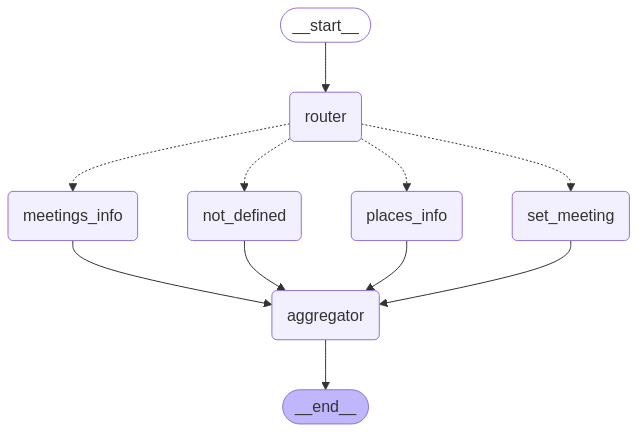

In [8]:
# Show the workflow
display(Image(personal_agent.get_graph().draw_mermaid_png()))

In [9]:
# function to simplify the tests
def test_workflow(query: str):
    outcome = personal_agent.invoke({"input": query})

    return outcome["output"]

In [10]:
query = """Give me all the free slot for 2025-02-26"""

outcome = test_workflow(query)

print("")
print("Free meetings slots found:")
display(Markdown(outcome))

2025-03-04 10:31:09,090 - Calling MeetingsInfo
2025-03-04 10:31:09,790 - Calling Aggregator
2025-03-04 10:31:09,791 - aggregator: Aggregating outputs...



Free meetings slots found:


{'2025-02-26': ['8:00 - 13:00', '15:00 - 18:00']}

In [11]:
query = """Show me the free slot for 2025-03-09"""

outcome = test_workflow(query)

print("")
print("Free meetings slots found:")
print(outcome)

2025-03-04 10:31:12,124 - Calling MeetingsInfo
2025-03-04 10:31:12,805 - Calling Aggregator
2025-03-04 10:31:12,807 - aggregator: Aggregating outputs...



Free meetings slots found:
{'2025-03-09': ['8:00 - 13:00', '15:00 - 18:00']}


In [12]:
query = """I don't know what to ask for"""

outcome = test_workflow(query)

print("")
display(Markdown(outcome))

2025-03-04 10:31:15,331 - Calling NotDefined
2025-03-04 10:31:18,135 - Calling Aggregator
2025-03-04 10:31:18,136 - aggregator: Aggregating outputs...


### User Question
You have stated that you don't know what to ask for.

### Assistance
To better assist you, could you please provide more context or information about the topic or area you are interested in? This will help me narrow down the possibilities and provide more tailored guidance on what you can ask for.

Some examples of areas where you might need assistance include:
* General knowledge or trivia
* Technical support or troubleshooting
* Language translation or interpretation
* Education or learning resources
* Entertainment or leisure activities

Please provide more details or clarify your interests, and I will do my best to help you formulate a specific question or request.

In [13]:
query = """What are the top 5 chinese restaurants in Rome?"""

outcome = test_workflow(query)

print("")
display(Markdown(outcome))

2025-03-04 10:31:19,065 - Calling PlacesInfo
2025-03-04 10:31:25,441 - Calling Aggregator
2025-03-04 10:31:25,443 - aggregator: Aggregating outputs...


### Introduction to Chinese Restaurants in Rome
Rome, the capital city of Italy, is known for its rich culinary scene, which includes a variety of international cuisines, such as Chinese. To provide an accurate answer, I would need more information about your preferences, such as location, price range, and type of Chinese cuisine. However, I can give you a general overview of some highly-recommended Chinese restaurants in Rome.

### Top 5 Chinese Restaurants in Rome
Based on available reviews and ratings, here are five Chinese restaurants in Rome that are worth considering:
1. **Ristorante Cina**: Known for its traditional Chinese dishes and cozy atmosphere.
2. **Jin Yan**: Offers a wide range of Chinese cuisine, including Szechuan and Cantonese options.
3. **Ristorante Grande Muro**: Provides an extensive menu with a variety of Chinese dishes, including vegetarian and vegan options.
4. **Taverna Cina**: A popular spot for Chinese food, with a focus on traditional dishes and a lively atmosphere.
5. **Ristorante Peking**: Specializes in Peking-style cuisine, including the famous Peking duck.

### Additional Information Needed
To give you a more tailored answer, could you please provide more information about your preferences, such as:
* Location: Are you looking for restaurants in a specific area of Rome?
* Price range: Are you looking for budget-friendly options or high-end restaurants?
* Type of Chinese cuisine: Are you interested in a specific type of Chinese cuisine, such as Szechuan or Cantonese?

With more information, I can provide a more detailed and personalized answer to your question.

### Set Meeting

In [14]:
query = """Show me the free slot for 2025-03-09"""

outcome = test_workflow(query)

print("")
print("Free meetings slots found:")
print(outcome)

2025-03-04 10:31:26,363 - Calling MeetingsInfo
2025-03-04 10:31:27,060 - Calling Aggregator
2025-03-04 10:31:27,066 - aggregator: Aggregating outputs...



Free meetings slots found:
{'2025-03-09': ['8:00 - 13:00', '15:00 - 18:00']}


In [15]:
query = """Set a meeting for 9 march 2025 start at 10 end at 11"""

outcome = test_workflow(query)

print("")
display(Markdown(outcome))

2025-03-04 10:31:28,037 - Calling SetMeeting
2025-03-04 10:31:28,952 - Calling Aggregator
2025-03-04 10:31:28,953 - aggregator: Aggregating outputs...


date='2025-03-09' start_hour='10:00' end_hour='11:00'



meeting set on 2025-03-09 from 10:00 to 11:00

In [16]:
query = """Ok, then please Show me the free slot for 2025-03-09"""

outcome = test_workflow(query)

print("")
print("Free meetings slots found:")
print(outcome)

2025-03-04 10:31:29,903 - Calling MeetingsInfo
2025-03-04 10:31:30,608 - Calling Aggregator
2025-03-04 10:31:30,609 - aggregator: Aggregating outputs...



Free meetings slots found:
{'2025-03-09': ['8:00 - 10:00', '11:00 - 13:00', '15:00 - 18:00']}
